# Introduction

**Modèle "word2vec" pour la construction de vecteurs de mots**

Dans ce projet nous proposons d'implémenter le modèle word2vec **SKIP-GRAM** avec échantillonnage négatif (*skip-gram with negative sampling*), en appliquant la librairie **pytorch**. 

Ce projet est co-réalisé par:


1.   Wei HU (n° étudiant: 22018878)
2.   Yong-you KE (n° étudiant: 22023073)
3.   Vo Tuan Anh AN (n° étudiant: 22017834)



# Pré-traitement des données

Nous utilisons un corpus libre de droits issu du journal **"L'Est républicain"**. Chaque archive contient environ **40 millions** de mots (**26** fichiers de **100 000** phrases chacun, environ **1,6** million de mots chacun). Les fichiers sont au format **une phrase par ligne**, **segmentée en tokens**, et **les mots sont taggés** (on n'a pas besoin des tags). Certains mots composés ont été repérés (comme "parce_que").

In [1]:
import time
import os
os.environ['CUDA_VISIBLE_DEVICES']='0, 1, 2, 3'
import re
import numpy as np
#numpy.random.seed(12345)
from tqdm import tqdm # adding a process bar
import string
import random

class Data:
    """
        Préparation des données pour le modèle Word2Vec comme carte de mots (word map), table d'échantillonnage (sampling table), etc.

        Attributs: 
            data_file_path:     le fichier de données à lire
            min_prob_keep:      le seuil de proba à sélectionner un mot
            neg_pos_ratio:      la ratio entre un exemple positif et ses exemples négatifs aléatoirement échantionnés (combien d'exemples négatifs pour un exemple positif)
            window_size:        la taille de la fenêtre de mots
            w2nbocc:            le comptage du nombre d'occurrences de chaque mot, nécessaire pour le filtrage lexical
            w2i:                un dico mapping du mot à son indice
            i2w:                une liste des mots
            sent_cnt:           le comptage du nombre des phrases dans le corpus
            sent_length:        la longueur des phrases dans le corpus            
    """
    def __init__(self, f_name, min_keep, window_size, neg_pos_ratio):
        """
            Fonction init(): sert à l'initialisation de l'objet de la classe Data

            Arguments:
                f_name:     le nom du fichier de données à traiter
                min_cnt:    le nombre minimal des mots à traiter
        """
        self.data_file_path = f_name # le nom de fichier des données        
        self.min_prob_keep = min_keep # le seuil minimal permettant de garder un mot pour l'apprentissage ultérieur
        self.neg_pos_ratio = neg_pos_ratio # la ratio entre exemple positif et exemples négatifs aléatoirement échantionnonés (combien d'exemples négatifs pour un exemple positif)
        self.get_wrds() # téléchargement des données pré-traitées
        self.window_size = window_size # hyperparamètre: taille de la fenêtre de mots        
        self.subsample() # le sous-échantionnage pour obtenir des exemples "candidates" pour l'apprentissage                
        print('Le nombre d\'occurrences: %d' % sum(self.w2nbocc.values())) # affiche le nombre d'occurrences dans le corpus         
        print('Le nombre de mots: %d' % len(self.w2i)) # affiche le nombre de mots dans le corpus
        print('La nombre des phrases: %d' % (self.sent_cnt)) # affiche le nombre de phrases dans le corpus
        print('La longueur des phrases: %d' % (self.sent_length)) # affiche la longueur des phrases dans le corpus
    
    def get_wrds(self):
        """
            Fonction get_wrds(): sert au pré-traitement de données

            Returns:
                - None

        """
        print("Lecture de données...") # signale le commencement de lecture de données 
        self.input_file = open(self.data_file_path, 'r', encoding='utf-8') # le fichier de données               
        self.sent_cnt = 0 # le comptage des phrases
        self.sent_length = 0 # la taille des phrases du corpus  
        self.real_tokens_len = 0 # la taille des tokens    
        self.w2nbocc = dict() # un dico du mots à son nombre d'occurrences
                
        self.occurrences = [] # une liste d'occurrences
        self.sentence = [] # la phrase
        self.tokenized_sentences = [] # toutes les phrases tokenisées      

        for line in self.input_file: # pour chaque ligne du fichier
            self.sent_cnt +=1 # le comptage des phrases            
            ls_tokens_in_line = line.strip().split(' ') # tokenise la ligne
            self.sent_length +=len(line) # la longueur des phrases
            for token in ls_tokens_in_line: # pour chaque token dans la phrase
                ls_elem_in_a_token = token.split("/") # supprime "/" du token                
                candidate_token = ls_elem_in_a_token[0].translate(str.maketrans('', '', string.punctuation)) # supprimer toutes les ponctuations
                if len(candidate_token)>0 and not any(char.isdigit() for char in candidate_token): # on ne garde que des token-mots (pas de token-chiffres)
                    self.occurrences.append(candidate_token) # ajoute le token-candidate à la liste d'occurrences
                    self.sentence.append(candidate_token) # ajoute le token-candidate à la liste-phrase
                    try:
                        self.w2nbocc[candidate_token] +=1 # plus une fois d'apparition 
                    except:
                        self.w2nbocc[candidate_token] = 1 # compte une fois si le otken-candidate n'existe pas dans le dico "w2nbocc"
            self.tokenized_sentences.append(self.sentence) # ajoute une phrase à la liste de phrases tokenizées
            self.real_tokens_len += len(self.sentence) # additionne la longueur réelle des tokens
            self.sentence = [] # rend vide la liste-phrase

        self.w2i = dict() # un dico de mot à indice de mot
        self.i2w = dict() # un dico d'indice de mot à mot
        wid = 0 # crée une variable de comptage qui sert à affecter l'indice du mot        
        for token, cnt in self.w2nbocc.items(): # pour chaque token avec nb de fois d'apparition dans le dico "w2nbocc"           
            self.w2i[token] = wid # affecte une indice de mot
            self.i2w[wid] = token # affecte un mot            
            wid +=1 # l'indice de mot augmente 1
        self.wrd_cnt = len(self.w2i) # la taille du vocabulaire
        print('   Done.') # affiche "   Done." pour signaler la lecture finie
                        
       
    def subsample(self):
        """
            Fonction subsample(): sert au sous-échantillonnage des exemples à apprendre

            Returns:
                - les exemples sous-échantillonnés
        """

        self.sample_table = [] # crée un tableau d'exemples
        sample_table_size = 1e8 # la taille du tableau d'exemples       
       
        word_counts = np.asarray([v for v in self.w2nbocc.values()]) # une liste de nombres d'occurrences des mots converti en un tableau numpy
        word_counts_pow = word_counts**0.75 # "word_counts" exponentiel 0.75        
        total_words_pow = np.sum(word_counts_pow) # somme les nombres d'occurrences des mots exponentiels 0.75       
        word_fractions_pow = word_counts_pow/total_words_pow # normalise les nombres d'occurrences des mots exponentiels 0.75
        count = np.round(word_fractions_pow*sample_table_size) # initialise la taille du tableau des exemples
        for wid, c in enumerate(count): 
            self.sample_table += [wid] * int(c)
        self.sample_table = np.array(self.sample_table)       
        coef = 0.001 # coefficient pour contrôler l'agressivité avec laquelle nous sous-échantillonnons (Hyperparamètre: il est possible de le rectifier.)
        word_sample_rates = (np.sqrt(word_fractions_pow/coef) + 1) * (coef/word_fractions_pow) # la ratio d'échantillionnage des examples
        limited_word_subsambling_rates = np.clip(word_sample_rates, 0.0, 1.0) # limite les taux d'échantillonnage à une valeur maximale de 1,0         
        samples = [] # liste d'examples
        words = list(self.w2nbocc.keys()) # le vocab
        for i in range(len(words)): 
            word_proba = limited_word_subsambling_rates[i]            
            if word_proba > self.min_prob_keep: # si la proba d'echantillionnage d'un mot est supérieur à la proba minimale
                samples.append(words[i]) # garde le mot         
        return samples # rend les mots sous-échantillionnés

    def create_examples(self):
        """
            Fonction create_examples(): sert à créer des examples à partir des mots sous-échantillonnés
        """
        positif_examples = [] # examples positifs
        negatif_examples = [] # examples négatifs
        
        t0 = time.time() # time t0

        samples = self.subsample() # sous-échantionne les occurrences
        set_samples2i = set([self.w2i[sample] for sample in samples]) # un set de mots sous-échantillionné

        t1 = time.time() # time t1        

        """
            La création des examples positifs et négatifs:
                - example positif: (target, pos_before_target, 1), (target, pos_after_target, 1)
                - example négatif: (target, negatif, 0)
        """
        for sent in self.tokenized_sentences: # pour chaque phrase tokenisée
            for i in range(0, len(sent)): # itère à travers la phrase                 
                pos_before_target = 0 # l'occurrence positive précédente du target
                pos_after_target = 0 # l'occurrence positive suivante du target 
                sent2i = [self.w2i[token] for token in sent] # pour chaque phrase: du token à l'indice du token
                set_sent2i = set(sent2i) # un set d'indices de token dans chaque phrase

                t_s = time.time() # temps initial
                for j in range(1, self.window_size+1): # dans la fenêtre de mots                   
                    
                    t1_1 = time.time() # temps t1_1
                    target = sent2i[i] # target à l'indice i dans la phase                     
                    pool = list(set_samples2i - set_sent2i) # dans samples il y a peut-être des mots contextes positifs, pool ne contient que des mots contextes négatifs 

                    t2 = time.time() # temps t2
                    
                    neg_sample_ixs = np.random.randint(len(pool), size=self.neg_pos_ratio) # choisit aléatoirement les indexes du pool

                    t3 = time.time() # temps t3
                    
                    """
                        Crée des exemples positifs et négatifs:
                            --> les deux conditions verifient que l'index ne dépassent pas le range:
                                - (i-j): le j-eme mot avant le mot cible i,
                                - (i+j): le j-eme mot après le mot cible i
                    """
                    if (i-j)>=0:      
                        pos_before_target = sent2i[i-j]
                        positif_examples.append((target, pos_before_target, 1))

                        for idx in range(0, self.neg_pos_ratio):
                            negatif_examples.append((target, pool[neg_sample_ixs[idx]], 0)) 

                    if (i+j)<len(sent): 
                        pos_after_target = sent2i[i+j] 
                        positif_examples.append((target, pos_after_target, 1)) 

                        for idx in range(0, self.neg_pos_ratio):
                            negatif_examples.append((target, pool[neg_sample_ixs[idx]], 0))                     
    
                    t4 = time.time() # temps t4                    
                t_f = time.time() # temps final                
        return positif_examples, negatif_examples # rend les examples positifs et négatifs

    def save_examples(self, pos_examples, neg_examples, pos_file, neg_file): 
        """
            Fonction save_examples(): sert à sauvegarder les exemples dans un fichier à tester si besoin

            Params:
                - pos_examples: examples positifs
                - neg_examples: examples négatifs
                - pos_file: fichier des postifs
                - neg_file: fichier des négatifs
            Return:
                - None
        """
        with open(pos_file,'w') as f_pos:
            for elem in pos_examples:
                f_pos.write(f"{elem[0]} {elem[1]} {elem[2]} \n")

        with open(neg_file,'w') as f_neg:
            for elem in neg_examples:
                f_neg.write(f"{elem[0]} {elem[1]} {elem[2]} \n")

        f_pos.close()
        f_neg.close()

    def load_examples(self, pos_file, neg_file):
        """
            Fonction load_examples(): sert à lire les exemples déjà crées pour ganger du temps en fichier
            
            Params: 
                - pos_file: fichier des positifs
                - neg_file: fichier des négatifs
            
            Return:
                - pos_ex: examples positifs
                - neg_ex: examples négatifs
        """

        pos_ex = []
        neg_ex = []

        with open(pos_file,'r',encoding='utf-8') as f_pos:
            for line in f_pos:
                elem = line.split()
                pos_ex.append((int(elem[0]),int(elem[1]),int(elem[2])))

        with open(neg_file ,'r',encoding='utf-8') as f_neg:
            for line in f_neg:
                elem = line.split()
                neg_ex.append((int(elem[0]),int(elem[1]),int(elem[2])))

        f_pos.close()
        f_neg.close()

        return pos_ex, neg_ex   

In [2]:
def nb_token(corpus):

  length = 0
  for sent in corpus:
      length += len(sent)
  return length

In [3]:
def test():
      a = Data('train_1000.txt', 0.5, 2, 4)
      #print(f"total tokens = {nb_token(a.tokenized_sentences)}")
      #print(a.real_tokens_len)
      pos_ex, neg_ex = a.create_examples()
      print(pos_ex[:5])
      print(neg_ex[:5])   

In [4]:
if __name__ == '__main__':
    corpus = 'train_1000.txt'
    test()    

Lecture de données...
   Done.
Le nombre d'occurrences: 12838
Le nombre de mots: 3509
La nombre des phrases: 1000
La longueur des phrases: 176850
[(2, 3, 1), (2, 4, 1), (3, 2, 1), (3, 4, 1), (3, 5, 1)]
[(2, 879, 0), (2, 1442, 0), (2, 1386, 0), (2, 934, 0), (2, 1242, 0)]


# Construction du modèle

In [5]:
import torch
torch.cuda.empty_cache()
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import os
os.environ['CUDA_VISIBLE_DEVICES']='2, 3'

class SGNS(nn.Module):
    """Le modèle Skip-Grame.
    
    Attributs:
        emb_size: la taille de l'embedding
        emb_dimension: le nombre de dimensions de l'embedding, typiquement de 50 à 500.
        w: l'embedding pour le mot cible (target)
        c: l'embedding pour les mots de contexte
    """
    def __init__(self, voc_size, emb_dim):
        """
            Fonction init(): sert à l'initialisation de l'objet de la classe SGNS

            Params:
                - voc_size: la taille du vocab
                - emb_dim: les dimensions de l'embedding
            
            Return:
                - dots: produits scalaires entre embeddings de targets et embeddings de contextes
        """
        super(SGNS, self).__init__()        
        self.emb_dimension = emb_dim # le nb de dimensions de l'embedding        
        self.w = nn.Embedding(voc_size, emb_dim) # Target word embeddings: shape [VOCAB_SIZE, EMB_DIM]        
        self.c = nn.Embedding(voc_size, emb_dim) # Context embeddings: shape [VOCAB_SIZE, EMB_DIM]

    def forward(self, tgt, ctx):       
        """
            Fonction foward(): sert à la propagation avant pour calculer des scores servant à la prédiction

            Params: 
                - tgt: un tenser de 1 dimension contenant les ids du mot cible (target)
                - ctx: un tenseur de 2 dimensions contenant les ids de contextes positifs et négatifs pour chaque target
        """
        tgt_emb = self.w(tgt) # recherche les plongements pour les mots cibles ayant la shape: (batch size, embedding dimension)         
        n_batch, emb_dim = tgt_emb.shape
        n_ctx = ctx.shape[1]
        tgt_emb = tgt_emb.view(n_batch, 1, emb_dim) # visualise ceci comme un tenseur à 3 dimensions, ayant la shape (batch size, 1, embedding dimension)
        ctx_emb = self.c(ctx) # recherche les plongements pour les mots de contexte positifs et négatifs ayant la shape: (batch size, nbr contexts, emb dim) 
        ctx_emb = ctx_emb.transpose(1, 2) # transpose le tenseur pour la multiplication matricielle ayant la shape: (batch size, emb dim, nbr contexts)       
        dots = tgt_emb.bmm(ctx_emb) # calcule les produits scalaires entre les plongements de mots cibles et les plongements de contexte sous la forme de multiplication matricielle par lots (bmm). Shape: (batch size, 1, nbr contexts)
        dots = dots.view(n_batch, n_ctx) # visualise ce résultat comme un tenseur à 2 dimensions. Shape: (batch size, nbr contexts)

        return dots

    def save(self, i2w, file_name, using_cuda):
        """
            Fonction save(): sert à sauvegarder les embeddings dans un fichier à tester si besoin

            Params:
                - i2w: la concordance entre indice de mot et mot
                - file_name: le nom de fichier
                - using_cuda: l'utilisation du cuda
            Return:
                - None
        """
        if using_cuda:
            embedding = self.w.weight.cpu().data.numpy()
        else:
            embedding = self.w.weight.data.numpy()
        f_emb = open(file_name, 'w')
        f_emb.write('%d %d\n' % (len(i2w), self.emb_dimension))
        for wid, w in i2w.items():
            e = embedding[wid]
            e = ' '.join(map(lambda x: str(x), e))
            f_emb.write('%s %s\n' % (w, e))
    
        

In [6]:
def test():
    model = SGNS(100, 100)
    id2word = dict()
    for i in range(100):
        id2word[i] = str(i)
    model.save(id2word, 'test_embeddings.txt', True)

In [7]:
if __name__ == '__main__':
    test()

In [8]:
# Verify if the appending is successfully executed
with open('test_embeddings.txt', 'r') as testwritefile:
    print(testwritefile.read())

100 100
0 1.1501669 1.4760838 0.67698455 -0.32354495 -1.1800938 -1.0540038 -0.50317377 0.5211786 0.46425402 1.3450947 0.88669133 -0.83704287 0.7512531 -1.3995137 1.1521314 0.048893865 -0.098768875 -0.32745755 -0.7247719 -0.41563165 0.072689034 0.5603554 0.36878064 -0.87869453 3.6432016 -0.44329146 1.1072073 1.3800406 0.40260485 0.15121575 1.0095687 0.9032161 -0.3810917 -1.2818514 -0.6964817 -0.44037068 -0.073551305 1.3840078 -2.1513324 0.86194044 0.8572822 0.16559592 1.3952799 0.28529063 -1.3165761 0.98782045 -0.65995574 -0.5925281 0.49553806 0.69542813 0.13521796 -1.0909865 0.37226093 -0.8932248 0.28563786 -1.0198376 0.44032165 -1.5100541 -0.65333945 0.79872346 -0.46313334 -0.017585931 -0.6292399 1.3494419 0.2283997 0.44532916 -0.40872502 -0.77659875 0.28318304 -1.7684703 0.8314647 0.09082951 -0.36208004 1.28993 -0.60919076 0.19018027 -1.4841123 -0.012919317 1.4741589 1.2669307 0.56184006 -1.2683287 -0.18672599 -0.79715633 -0.33634526 -1.872319 -0.24170503 -1.3340789 0.076452546 -2.00

# Word2Vec

In [9]:
import time
import numpy
from torch.autograd import Variable
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import sys
from random import shuffle
import os
os.environ['CUDA_VISIBLE_DEVICES']='2, 3'
# check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")
torch.manual_seed(1)

CPU


In [10]:
class Word2Vec:
    def __init__(self,
                 input_file_name,
                 output_file_name,                
                 emb_dimension=100,
                 batch_size=10,
                 window_size=2,
                 epochs=5,                 
                 optimizer='adam', 
                 initial_lr=0.025,
                 neg_pos_ratio=4,
                 min_keep=0.5
                 ):
        """
        Args:
            - input_file_name: le fichier d'entrée
            - output_file_name: le fichier de sortie
            - emb_dimension: le nombre de dimensions de l'embedding
            - batch_size: un sous-ensemble des exemples d'apprentissage 
            - window_size: la taille de la fenêtre lexicale
            - epochs: le nombre d'epochs
            - optimizer: l'optimiseur
            - initial_lr: le taux d'apprentissage initial.
            - neg_pos_ratio: la ratio entre un exemple positif et des exemples négatifs
            - min_keep: la probabilité minimale de garder une occurrence pour la transmettre en exemple d'apprentissage 
            

        Returns:
            None.
        """        
        self.data = Data(input_file_name, min_keep, window_size, neg_pos_ratio) # données
        self.input_file_name = input_file_name # le fichier d'entrée
        self.output_file_name = output_file_name # le fichier de sortie
        self.pos_file = "pos_" + input_file_name # le fichier des exemples positifs
        self.neg_file = "neg_" + input_file_name # le fichier des exemples négatifs
        self.neg_pos_ratio = neg_pos_ratio # la ratio entre exemple positif et exemples négatifs
        self.emb_size = len(self.data.w2i) # la taille de l'embedding
        self.emb_dimension = emb_dimension # les dimensions de l'embedding
        self.batch_size = batch_size # la taille du batch
        self.epochs = epochs # les epochs
        self.initial_lr = initial_lr # le taux d'apprentissage        
        self.window_size = window_size # la taille de fenêtre        
        self.momentum = 0.5  # le momentum
        self.model = SGNS(self.emb_size, self.emb_dimension) # le modèle
        self.using_cuda = torch.cuda.is_available() # l'utilisation du cuda
        if self.using_cuda: # True
            self.model.cuda() # le modèle est entraîné sur le cuda
        if optimizer == 'adam': # l'optimiseur 'adam'
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.initial_lr)
        elif optimizer == 'sgd': # l'optimiseur 'sgd'
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=initial_lr,momentum =self.momentum)        
        self.loss_function = nn.BCEWithLogitsLoss(reduction = 'sum') # la fonction de perte
        self.train_losses = [] # les pertes d'apprentissage
        self.valid_losses = [] # les pertes de validation
        self.results = [] # les résultats

        self.preprocessing = 0 # le temps de pré-traitement
        self.t_training = 0 # le temps d'apprentissage
   
    def make_batch(self, targets, c_pos, c_neg, y_pos, y_neg, position):
        """
             Fonction make_batch(): sert à créer des batches de mots cibles, des contextes positifs et négatifs et des gold labels positifs et négatifs

             Params:
                    - targets: les cibles
                    - c_pos: contextes positifs
                    - c_neg: contextes négatifs
                    - y_pos: gold labels positifs
                    - y_neg: gold labels négatifs
                    - position: la position

            Returns:
                    - tgt: targets (cibles)
                    - c_pos: contextes positifs
                    - c_neg: contextes négatifs
                    - y_pos: gold labels positifs
                    - y_neg: gold labels négatifs  
        """

        k = self.neg_pos_ratio

        # découpe chaque type d'entrées en taille du mini-batch et les transforme en tensor
        tgt = torch.as_tensor(targets[position:position + self.batch_size])
        c_pos = torch.as_tensor(c_pos[position:position + self.batch_size])
        y_pos = torch.as_tensor(y_pos[position:position + self.batch_size])
        c_neg = torch.as_tensor(c_neg[position*k:(position + self.batch_size)*k])
        y_neg = torch.as_tensor(y_neg[position*k:(position + self.batch_size)*k])

        # crée un mini-batch 
        if (position + self.batch_size) <= len(targets): # un mini-batch entier
            c_pos = c_pos.view(self.batch_size, 1)  # (batch_size, 1)
            c_neg = c_neg.view(self.batch_size, k)  # (batch_size, neg_pos_ratio)
            y_pos = y_pos.view(self.batch_size, 1)  # (batch_size, 1)
            y_neg = y_neg.view(self.batch_size, k)  # (batch_size, neg_pos_ratio)
       
        else:  # les derniers exemples qui ne font pas un mini-batch complet
            c_pos = c_pos.view(len(targets)-position, 1)
            c_neg = c_neg.view(len(targets)-position, k)
            y_pos = y_pos.view(len(targets)-position, 1)
            y_neg = y_neg.view(len(targets)-position, k)

        return tgt, c_pos, c_neg, y_pos, y_neg

    def dataset_split(self, pos_examples, neg_examples):
        """
            Fonction dataset_split(): sert à diviser le dataset

            Params:
                    - pos_examples: examples positifs
                    - neg_examples: examples négatifs
            
            Returns:
                    - pos_train: examples positifs d'apprentissage
                    - pos_valid: examples positifs de validation
                    - neg_train: examples negatifs d'apprentissage
                    - neg_valid: examples négatifs de validation
        """

        split = round(len(pos_examples)*0.8)
        k = self.neg_pos_ratio

        pos_train = pos_examples[0:split]
        pos_valid = pos_examples[split:]
        neg_train = neg_examples[0:split*k]
        neg_valid = neg_examples[split*k:]

        return pos_train, pos_valid, neg_train, neg_valid

    def apprentissage(self):
        """
            Fonction apprentissage(): sert à entraîner le modèle
        """

        preprocessing_start = time.time() # au début du temps de pré-traitement

        # les exemples positifs et négatifs
        if os.path.exists(self.pos_file) and os.path.exists(self.neg_file):
            print(f"Apprendre sur {self.input_file_name} avec lecture des exemples existents..." )
            pos_examples, neg_examples = self.data.load_examples(self.pos_file, self.neg_file)
        else:
            print(f"Apprendre sur {self.input_file_name} en sauvegardant les exemples..." )
            pos_examples, neg_examples = self.data.create_examples() # les exemples positifs et négatifs
            self.data.save_examples(pos_examples, neg_examples, self.pos_file, self.neg_file)

        # crée un jeu d'apprentissage et un jeu de validation
        pos_train, pos_valid, neg_train, neg_valid = self.dataset_split(pos_examples, neg_examples)

        (tn_targets_pos, tn_contexts_pos, tn_labels_pos) = zip(*pos_train)
        (vd_targets_pos, vd_contexts_pos, vd_labels_pos) = zip(*pos_valid)
        (tn_targets_neg, tn_contexts_neg, tn_labels_neg) = zip(*neg_train)
        (vd_targets_neg, vd_contexts_neg, vd_labels_neg) = zip(*neg_valid)

        # examples = positif_examples + negatif_examples # l'ensemble des exemples d'apprentissage

        training_start = time.time()
        self.preprocessing = training_start-preprocessing_start

        process_bar = tqdm(range(int(self.epochs)))

        print()
        print('Apprentissage...')
        print()

        for i in process_bar:
            epoch_start = time.time() # au début de l'epoch

            total_loss = 0
            batch_idx = 0

            # entraînement
            self.model.train()
            n_train_batch = np.ceil(len(tn_targets_pos)/self.batch_size)
            while batch_idx < len(tn_targets_pos):           

                #(targets, contexts, labels) = zip(*batch)                        
                t, c_pos, c_neg, y_pos, y_neg = self.make_batch(tn_targets_pos, \
                                                tn_contexts_pos, tn_contexts_neg, \
                                                tn_labels_pos, tn_labels_neg, batch_idx)
                              
                c = torch.cat([c_pos, c_neg], dim=1)  # concatène les contextes positifs et négatifs ayant la shape: (batch size, 1 + neg-pos ratio)                
                self.optimizer.zero_grad() # remise à zéro des gradients
                scores = self.model(t, c) # calcule les scores en faisant un produit scalaire du target embeddings avec le contexte embeddings
                y = torch.cat([y_pos, y_neg], dim=1) # concatène les gold labels positifs et négatifs, shape: (batch size, 1 + neg-pos ratio)
                loss = self.loss_function(scores, y.float()) # calcule la perte
                loss.backward() # calcule les gradients et met à jour les embeddings
                self.optimizer.step() # optimise les paramètres
                # accumule la perte d'entraînement sur tous les batchs
                # `loss` est un tenseur contenant une valeur à partir du tenseur 
                # la fonction '.item()` rend juste la valeur Python 
                total_loss += loss.item()
                batch_idx += self.batch_size # le batch indice         

            # validation
            valid_loss = 0
            batch_idx = 0

            self.model.eval() # pour définir les couches de suppression et de normalisation par batchs en mode d'évaluation avant d'exécuter l'inférence
            n_valid_batch = np.ceil(len(vd_targets_pos)/self.batch_size) # n_batch = le nb de minibatch dans une époque. C'est pour calculer la perte d'une époque: la perte moyenne par batch.
            while batch_idx < len(vd_targets_pos):          

                #(targets, contexts, labels) = zip(*batch)                        
                t, c_pos, c_neg, y_pos, y_neg = self.make_batch(vd_targets_pos, \
                                                vd_contexts_pos, vd_contexts_neg, \
                                                vd_labels_pos, vd_labels_neg, batch_idx)
                
                c = torch.cat([c_pos, c_neg], dim=1) # concaténe contextes positifs et négatifs -- @@ shape: (batch size, 1 + neg-pos ratio)                
                scores = self.model(t, c) # calcule les scores en faisant un produit scalaire du target embeddings avec le contexte embeddings
                y = torch.cat([y_pos, y_neg], dim=1) # concatène les labels gold (prédits) positifs et négatifs -- @@ shape: (batch size, 1 + neg-pos ratio)
                loss = self.loss_function(scores, y.float()) # calcule la perte
                valid_loss += loss.item()
                batch_idx += self.batch_size    

            epoch_end = time.time() # à la fin de l'epoch
            t_epoch = epoch_end-epoch_start # la durée de l'epoch

            self.results.append(t_epoch)
            self.train_losses.append(total_loss/n_train_batch) # moyenne les pertes d'apprentissage des batchs du corpus d'entraînement
            self.valid_losses.append(valid_loss/n_valid_batch) # moyenne les pertes d'apprentissage des batchs du corpus de validation

            # par de processus
            process_bar.set_description("Loss: %0.8f, lr: %0.6f" %
                                        (loss,
                                         self.optimizer.param_groups[0]['lr']))
            
            # rectifie automatiquement le taux d'apprentissage
            if i * self.batch_size % 100000 == 0: 
                lr = self.initial_lr * (1.0 - 1.0 * i / (self.epochs * (len(pos_examples) + len(neg_examples))/self.batch_size))
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = lr

        print()
        print(f"Training losses : {self.train_losses}")
        print(f"Validation losses : {self.valid_losses}")
        print()

        training_end = time.time()
        self.t_training = training_end - training_start

        print("Total preprocessing time : %0.6f (s)" % self.preprocessing)
        print("Total training time : %0.6f (s)" % self.t_training)
        print()
        print('     Done.') 
        print()

        self.model.save(self.data.i2w, self.output_file_name, self.using_cuda)

In [11]:
if __name__ == '__main__':
    w2v = Word2Vec(input_file_name = 'train_50.txt', output_file_name = 'test_w2v.txt')
    w2v.apprentissage()

Lecture de données...


FileNotFoundError: ignored

In [ ]:
# Verify if the appending is successfully executed
with open('test_w2v.txt', 'r') as testwritefile:
    print(testwritefile.read())

## Main

Changer les paramètres et déclencher l'algorithme ici.

In [48]:
import itertools
import pandas as pd

if __name__ == '__main__':

  # hyperparamètres
  input_file_name = 'train_100.txt'
  ls_embedding_dim = [200] # [200] #[25,50,100]  # [25,50,100 | 200,300]
  ls_batch_size = [16] # [1024] # [1024] # [128,256,512,1024] # [16,32,64 | 128,256,512,1024]
  ls_neg_pos_ratio = [4] # [4]    
  ls_min_keep = [0.7] # [0.5,0.6,0.7] # [0.5,0.6,0.7]
  ls_epochs= [30] # [20]  # [15,20,30]
  optimizer = 'adam'
  ls_lr = [1e-3] # [1e-1,1e-3,1e-5] # [1e-1,1e-3,1e-5]

  ls_hparams = [ls_embedding_dim,ls_batch_size,ls_neg_pos_ratio, ls_min_keep, ls_epochs, ls_lr]
  ls_result = []

  # teste toutes les combinaisons d'hyperparamètre en boucle
  for tup in list(itertools.product(*ls_hparams)):

      emb_dimension = tup[0]
      batch_size = tup[1]
      neg_pos_ratio = tup[2]
      min_keep = tup[3]
      epochs = tup[4]
      lr = tup[5]

      w2v = Word2Vec(input_file_name = input_file_name,
                    output_file_name = 'test_w2v.txt',
                    emb_dimension = emb_dimension,
                    batch_size = batch_size,
                    neg_pos_ratio = neg_pos_ratio,
                    min_keep = min_keep,
                    epochs = epochs,
                    optimizer = optimizer,
                    initial_lr = lr)
      w2v.apprentissage()

      ls_result.append([input_file_name, *tup, w2v.preprocessing, w2v.t_training/epochs, w2v.t_training, *w2v.results, w2v.train_losses, w2v.valid_losses])

  # sauvegarde les résultats en DataFrame et en fichier .csv
  col_epoch = [f"T_Epoch_{e+1}" for e in range(0,w2v.epochs)]
  columns = ["Input_file",
             "Emb_dim",
             "Batch_size",
             "Neg_pos_ratio",
             "Min_keep",
             "Epochs",
             "Learning_rate",
             "T_Preproccessing",
             "T_Training per epoch",
             "T_Training"] + col_epoch +\
            ["Training_loss", 
             "Validation_loss"]


  df = pd.DataFrame(ls_result, columns = columns)
  df.to_csv("results.csv")

Lecture de données...
   Done.


  0%|          | 0/30 [00:00<?, ?it/s]

Le nombre d'occurrences: 959
Le nombre de mots: 465
La nombre des phrases: 100
La longueur des phrases: 14098
Apprendre sur train_100.txt avec lecture des exemples existents...

Apprentissage...



Loss: 0.37546563, lr: 0.001000: 100%|██████████| 30/30 [00:06<00:00,  4.85it/s]


Training losses : [449.2289897109523, 383.810503318093, 329.0174842140891, 283.18457567619555, 243.77453039920692, 209.83728568337182, 180.82550194480203, 156.10202999692976, 135.0096571373217, 116.81533277107008, 101.05030392155503, 87.509741563508, 76.0106386011297, 66.23161336725408, 57.85520181944876, 50.62865134296995, 44.41706914468245, 39.12053173383077, 34.61300511143424, 30.77107121583187, 27.482349997217003, 24.646134213245276, 22.175776328101303, 20.00515663461252, 18.09487865079533, 16.415332499417392, 14.933155559409748, 13.622493120576395, 12.46502893187783, 11.443103804732814]
Validation losses : [423.4380832044851, 404.7917797849292, 392.3694981762341, 384.86797608648027, 378.9533819130489, 374.09615173793975, 370.16154588120327, 367.0387744392668, 364.5530921291737, 362.58996347870146, 361.0202373606818, 359.6919637116648, 358.52635243393127, 357.52247642122563, 356.66789028048515, 355.9300599084014, 355.2809032698472, 354.70001560307685, 354.1746348305827, 353.706518

In [ ]:
print(len(columns))

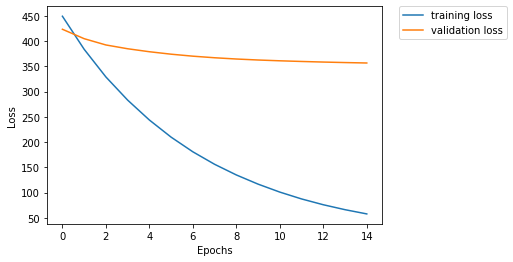

In [49]:
import matplotlib.pyplot as plt


plt.plot(w2v.train_losses[:15],label="training loss")
plt.plot(w2v.valid_losses[:15],label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


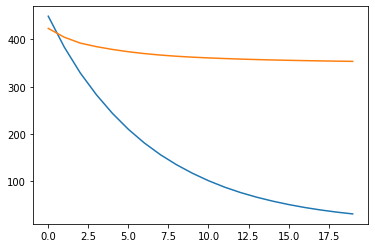

In [50]:
plt.plot(w2v.train_losses[:20])
plt.plot(w2v.valid_losses[:20])
plt.show()


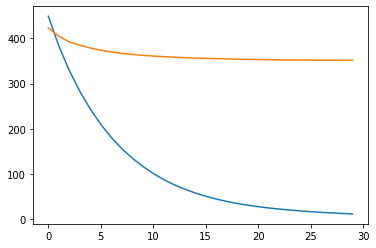

In [51]:
plt.plot(w2v.train_losses)
plt.plot(w2v.valid_losses)
plt.show()

In [ ]:
# Verify if the appending is successfully executed
with open('results.csv', 'r') as testwritefile:
    print(testwritefile.read())